#**Fake News Classification**

The following notebook presents a solution to the automatic classification of news articles based on their truth value. I present a Multinomial Naiive Bayes classifier (*FakeNewsClassifier*), which is able to classify texts as 'real' (0) or 'fake' (1) with around 75% accuracy.

The *FakeNewsClassifier* is compared to the Gaussian and Multinomial Naiive Bayes classifiers from Scikit-learn's library for performance evaluation. Each classifier outputs time statistics, accuracy, and classification metrics.

The second part of the project evaluates the effect of differing dataset sizes on accuracy rates. This is evaluated on both the *FakeNewsClassifier* and the two Naiive Bayes classifiers from Scikit-learn.

The third part of the project proposes additional tests:
1. The dataset is evaluated on the k-Nearest Neighbor classifier from Scikit-learn. The evaluation takes into account differing dataset sizes and distance heuristics.
2. The *FakeNewsClassifier* is tweaked to create the *NewsClassifier* and is evaluated on a dataset with a simpler task, i.e. classifying news articles as either pertaining 'business' or 'sports'. This test serves as a verification of the classifier's functionality outside of the first dataset.

Datasets can be found at:
* Fake News: https://www.kaggle.com/datasets/iamrahulthorat/fakenews-csv
* News Articles: https://www.kaggle.com/datasets/asad1m9a9h6mood/news-articles

##**Set-Up**

In [ ]:
import csv, re, nltk, math, time, random, pickle
import matplotlib.pyplot as plt
from sklearn import metrics
nltk.download('stopwords')

from google.colab import drive
drive.mount('/content/gdrive')

%cd '/content/gdrive/MyDrive/Machine Learning/Final Project'

In [ ]:
## Input Creation ##
data = []
with open('fakenews.csv') as filein: #reads in the csv file
  reader = csv.reader(filein)
  for i, row in enumerate(reader):
    if i != 0: #skips the first row, i.e. header
      data.append((row[0], row[1]))
random.shuffle(data) #shuffles the data

with open('evaulation_datasetZ.txt', 'wb') as fout:
  pickle.dump((data), fout) #saves this specific shuffling of the data in case of loss of connection

In [ ]:
## Input Restoration ##
with open('evaulation_dataset.txt', 'rb') as fin:
  data = pickle.load(fin)

stopwords = nltk.corpus.stopwords.words('english') #loads in stopwords

##**My Multinomial Naiive Bayes Classifier**

Accuracy of the *FakeNewsClassifier* rests around 75.5% when using the entire dataset.

The data preparation took 10.33 seconds, the classification 0.35 seconds, and the whole operation 10.68 seconds.

In [ ]:
## Classifier ##
class FakeNewsClassifier:
  """The FakeNewsClassifier class applies a Multinomial Naiive Bayes classification
  on text data.

  To instantiate the class, five arguments must be passed:
  (1) data : the dataset as a list of tuples with the first element containing
  the textual data and the second element its classification
  (2) stopwords : a list of stopwords to be used to remove semantically vacant
  words from the vocabulary
  (3) skipbucket : the number of the bucket to be skipped in training and testing
  (4) datasize : an integer representing the decimal fraction of the dataset
  desired. For example if only 20% of the data is wanted, '.2' would be written
  for this argument. The default is '1,' i.e. all the data.
  (5) test : a Boolean value, which when set to true tests the accuracy of the
  classifier on the given dataset. Otherwise, the classifier is only trained,
  but not tested"""

  def __init__(self, data, stopwords, skipbucket, datasize = 1, test = False):
    start = time.time()
    print('Training...')

    self.vocabulary = {}
    self.prob = {}
    self.totals = {}
    self.stopwords = {}
    self.categories = []

    ## reduces the dataset ##
    data = self.reducedata(data, datasize)

    ## instantiates the buckets ##
    buckets = self.makebuckets(data)

    ## defines the categories ##
    for tup in data:
      try:
        int(tup[1])
        self.categories.append(tup[1])
      except:
        pass

    self.categories = set(self.categories)

    ## sets the stopwords ##
    for word in stopwords:
      self.stopwords[word] = 1

    ## counts token frequency and token totals for each category ##
    for category in self.categories:
      (self.prob[category], self.totals[category]) = self.train(buckets, category, skipbucket, stopwords)

    ## simplifies the vocabulary ##
    tbdeleted = []
    for word in self.vocabulary:
      if self.vocabulary[word] < 3:
        tbdeleted.append(word)

    for word in tbdeleted:
      del self.vocabulary[word]

    ## computes the probabilities ##
    lenvocab = len(self.vocabulary)
    for category in self.categories:
      denominator = self.totals[category] + lenvocab
      for word in self.vocabulary:
        if word in self.prob[category]:
          count = self.prob[category][word]
        else:
          count = 1
        self.prob[category][word] = (float(count + 1) / denominator)

    mid = time.time()
    print(f'     Data preparation elapsed {round(mid - start, 2)} seconds.')

    ## tests accuracy ##
    if test == True:
      print('\nTesting Accuracy...')
      self.test(buckets, skipbucket, output = True, mets = True)

    end = time.time()
    print('Time Statistics...')
    print(f'     Classification elapsed {round(end - mid, 2)} seconds.')
    print(f'     Total operation elapsed {round(end - start, 2)} seconds.')


  ## methods ##
  def train(self, buckets, category, skipbucket, stopwords):
    """The train() method does three tasks: (1) creates a vocabulary of all tokens
    and maintains a token count, (2) counts the frequency of every token, and (3)
    counts the total tokens (to be later used as a total count for each category).

    The method takes four arguments:
    (1) buckets : the training data divided previously into buckets
    (2) category : the current category being trained upon
    (3) skipbucket : the bucket number to be skipped to be used as a test set
    (4) stopwords : the list of stopwords to be excluded"""

    counts = {}
    total = 0
    for bucket, content in buckets.items():
      if bucket != skipbucket:
        for tup in content:
          text = re.sub('[\"\'’‘”“,.?!;:*()><&|»«]', '', tup[0])
          text = re.sub('[-/—[]–]', ' ', text)
          if tup[1] == category:
            tokens = text.split()

            for token in tokens:
              token = token.strip()
              token = token.lower()

              if token not in stopwords:
                self.vocabulary.setdefault(token, 0)
                self.vocabulary[token] += 1
                counts.setdefault(token, 0)
                counts[token] += 1
                total += 1

    return (counts, total)


  def makebuckets(self, data):
    """The makebuckets() method divides the dataset into 10 equally sized buckets.

    The method takes one argument:
    (1) data : the dataset in the form of a tuple with the first element containing
    the text data and the second element the classification"""

    divider = int(len(data) / 10)
    buckets = {}
    for i in range(0, 10):
      buckets[i + 1] = data[i * divider : (i * divider) + divider]

    return buckets


  def reducedata(self, data, datasize = 1):
    """The reducedata() method reduces the size of the dataset in order to test
    upon only a subsection of the data.

    The method takes two arguments:
    (1) data : the dataset
    (2) datasize : an integer representing the decimal fraction of the dataset
    desired. For example if only 20% of the data is wanted, '.2' would be written
    for this argument. The default is '1,' i.e. all the data."""

    bound = round(len(data) * datasize)

    return data[: bound]


  def classify(self, testcase):
    """The classify() method takes a single data element (one text), cleans its
    contents, and calculates the log probability of an individual token belonging
    to a specific class. It then adds that probability to a running total, which
    gets sorted to return the most likely class to which the text belongs.

    The method takes one argument:
    (1) testcase : the single text being considered for classification."""

    results = {}
    for category in self.categories:
      results[category] = 0

    text = re.sub('[\"\'’‘”“,.?!;:*()><&|»«]', '', testcase)
    text = re.sub('[-/—[]–]', ' ', text)
    tokens = text.split()

    for token in tokens:
      token = token.strip().lower()

      if token in self.vocabulary:
        for category in self.categories:
          try:
            results[category] += math.log(self.prob[category][token])
          except:
            self.prob[category].setdefault(token, 0)
            self.prob[category][token] += 1
            results[category] += math.log(self.prob[category][token])

    results = list(results.items())
    results.sort(key = lambda tuple: tuple[1], reverse = True)

    return results[0][0]


  def test(self, buckets, skipbucket, output = False, mets = False):
    """The test() method takes the test set, iterates through each text, and
    applies the classify() method to derive its predicted class. It counts the
    total cases and the total correct predictions to calculate the accuracy of
    the classifier on the given dataset.

    The method takes four arguments:
    (1) buckets : the training data divided previously into buckets
    (2) skipbucket : the bucket number previously skipped to be used here as a
    test set
    (3) output : a Boolean value, which when set to True outputs the accuracy of
    the classifier on the amount of test cases present in the bucket
    (4) mets : a Boolean value, which when set to True outputs the classification
    report from Scikit-Learn"""

    total = 0
    correct = 0
    y_test = []
    y_pred = []
    for bucket, content in buckets.items():
      if bucket == skipbucket:
        for tup in content:
          result = self.classify(tup[0])
          if result != None:
            total += 1
            y_test.append(tup[1])
            y_pred.append(result)

            if result == tup[1]:
              correct += 1

    if output == True:
      print(f'     Accuracy is {round(((float(correct) / total) * 100), 2)}% with {total} test cases.\n')

    if mets == True:
      print('Metrics...')
      print(metrics.classification_report(y_test, y_pred, zero_division = 0))

    return float(correct) / total


fnc = FakeNewsClassifier(data, stopwords, 5, test = True)

Training...
     Data preparation elapsed 10.33 seconds.

Testing Accuracy...
     Accuracy is 75.1% with 498 test cases.

Metrics...
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       279
           1       0.71      0.73      0.72       219

    accuracy                           0.75       498
   macro avg       0.75      0.75      0.75       498
weighted avg       0.75      0.75      0.75       498

Time Statistics...
     Classification elapsed 0.35 seconds.
     Total operation elapsed 10.68 seconds.


##**Scikit-Learn's Naiive Bayes Classifiers**

Accuracy of Scikit-learn's Gaussian Naiive Bayes classifier rests around 70.54%, whereas their Multinomial classifier scores higher at 75.35% when using the entire dataset. The Multinomial accuracy is on par with the *FakeNewsClassifier*.

The data preparation took 25.4 seconds (15.07 seconds slower than the FNC), the classification 8.99 seconds for the Gaussian (8.64 seconds slower than the FNC) and 2.37 seconds for the Multinomial (2.02 seconds slower than the FNC), and finally, the whole operation 36.76 seconds (26.08 seconds slower than the FNC).

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics

In [ ]:
def scikitbayes(data):
  """The scikitbayes() function prepares data to be used by the Scikit-learn
  library's diverse classifiers. It automatically outputs time statistics,
  accuracy measurements, and the classification report from Scikit-learn. The
  function returns the accuracy scores for both the Gaussian and Multinomial
  classifiers.

  The function takes one argument:
  (1) data : the dataset as a list of tuples with the first element containing
  the textual data and the second element its classification"""

  start = time.time()
  print('Training...')

  ## creates the vocabulary following the FakeNewsClassifier's same procedure ##
  vocab = {}
  for tup in data:
    text = re.sub('[\"\'’‘”“,.?!;:*()><&|»«]', '', tup[0])
    text = re.sub('[-/—[]–]', ' ', text)
    for token in text.split():
        token = token.lower().strip()
        if token not in vocab:
          vocab[token] = 1
        else:
          vocab[token] += 1

  ## defines the dimensions of the matrix ##
  matrix = lil_matrix((len(data), len(vocab)))

  ## assigns ids to each token and article ##
  token_ids = {token : i for i, token in enumerate(vocab)}

  ## populates a matrix ##
  classifications = []
  for i, tup in enumerate(data):
    text = re.sub('[\"\'’‘”“,.?!;:*()><&|»«]', '', tup[0])
    text = re.sub('[-/—[]–]', ' ', text)

    classifications.append(tup[1])

    for token in text.split():
      token = token.lower().strip()
      matrix[i, token_ids[token]] += 1

  ## assigns content to variables for scikit-learn's classifiers ##
  X = matrix.toarray()
  y = np.array(classifications)

  ## clean up ##
  del vocab
  del matrix
  del token_ids
  del classifications

  ## splits and prepares the data ##
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0, train_size = 0.9)

  mid = time.time()
  print(f'     Data preparation elapsed {round(mid - start, 2)} seconds.\n')

  print('Testing Accuracy...')
  ## Gaussian Naiive Bayes Classifier ##
  gnb = GaussianNB()
  y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)
  print(f"     Scikit-Learn's Gaussian Naiive Bayes Classifier's accuracy is {round(((y_test == y_pred_gnb).sum() / X_test.shape[0]) * 100, 2)}% with {X_test.shape[0]} test cases.")
  accuracy_gnb = ((y_test == y_pred_gnb).sum() / X_test.shape[0])
  endG = time.time()

  ## Multinomial Naiive Bayes Classifier ##
  mnb = MultinomialNB()
  y_pred_mnb = mnb.fit(X_train, y_train).predict(X_test)
  print(f"     Scikit-Learn's Multinomial Naiive Bayes Classifier's accuracy is {round(((y_test == y_pred_mnb).sum() / X_test.shape[0]) * 100, 2)}% with {X_test.shape[0]} test cases.\n")
  accuracy_mnb = ((y_test == y_pred_mnb).sum() / X_test.shape[0])
  end = time.time()

  print('Metrics...')
  print('     Gaussian Naiive Bayes:\n', metrics.classification_report(y_test, y_pred_gnb, zero_division = 0))
  print('     Multinomial Naiive Bayes:\n', metrics.classification_report(y_test, y_pred_mnb, zero_division = 0))

  print('Time Statistics...')
  print(f'     Gaussian classification elapsed {round(endG - mid, 2)} seconds.')
  print(f'     Multinomial classification elapsed {round(end - endG, 2)} seconds.\n')
  print(f'     Total operation elapsed {round(end - start, 2)} seconds.\n')

  return accuracy_gnb, accuracy_mnb

accuracy_gnb, accuracy_mnb = scikitbayes(data)

Training...
     Data preparation elapsed 25.4 seconds.

Testing Accuracy...
     Scikit-Learn's Gaussian Naiive Bayes Classifier's accuracy is 65.33% with 499 test cases.
     Scikit-Learn's Multinomial Naiive Bayes Classifier's accuracy is 73.75% with 499 test cases.

Metrics...
     Gaussian Naiive Bayes:
               precision    recall  f1-score   support

           0       0.71      0.70      0.71       297
           1       0.57      0.59      0.58       202

    accuracy                           0.65       499
   macro avg       0.64      0.64      0.64       499
weighted avg       0.66      0.65      0.65       499

     Multinomial Naiive Bayes:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78       297
           1       0.68      0.66      0.67       202

    accuracy                           0.74       499
   macro avg       0.73      0.73      0.73       499
weighted avg       0.74      0.74      0.74       499

Tim

##**Testing Different Sized Datasets**

To test differing dataset sizes, I wrote a method into the *FakeNewsClassifier* which is able to scale the dataset to the desired percentage. I applied this scaling iteratively from 1 to 100 percent of the dataset and tested the accuracy. The results are graphed.

For the *FakeNewsClassifier*, accuracies had an upwards trajectory until around 75% of the dataset was used, at which point scores began to drop. This may be a sign of overtraining. The highest accuracy clocked in at 78.61% with 75% of the dataset. In general after about 50% of the dataset used, accuracies hovered in and around 70% and 78%.

For the Scikit-learn classifiers, the Gaussian has a downward trend until about 20% of the dataset, where it preceeds to increase until about 75% of the dataset, and then drops into a range where accuracies hover between 63% and 65%. The Multinomial levels out very quickly at about 10% of the dataset, where its accuracy varies around ~65% to ~81%. The highest accuracy hit 81.52% with 66% of the datset.

In [ ]:
## FakeNewsClassifier ##
x = []
y = []
for num in range(1, 101, 1):
  print(f'Testing accuracy with {num}% of dataset...')
  fnc = FakeNewsClassifier(data, stopwords, 5, (num / 100), test = True)

  newdata = fnc.reducedata(data, (num / 100))
  buckets = fnc.makebuckets(newdata)

  accuracy = fnc.test(buckets, 5)
  print('\n', '-'*150, '\n')

  x.append(num)
  y.append(accuracy)

plt.plot(x, y)
plt.ylabel('Classifier Accuracy in Percentages')
plt.xlabel('Percentage of Dataset Used')
plt.title('The Effect of Dataset Size on Accuracy for the FakeNewsClassifier')
plt.show()

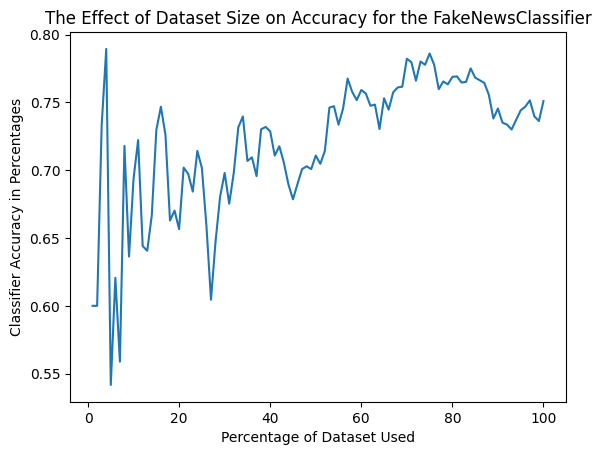

In [ ]:
## Scikit-learn's Gaussian and Multinomial Naiive Bayes classifiers ##
x = []
y_gnb = []
y_mnb = []
for num in range(1, 101, 1):
  print(f'Testing accuracy with {num}% of dataset...')
  newdata = fnc.reducedata(data, (num / 100))
  accuracy_gnb, accuracy_mnb = scikitbayes(newdata)
  print('-'*150, '\n')

  x.append(num)
  y_gnb.append(accuracy_gnb)
  y_mnb.append(accuracy_mnb)

plt.plot(x, y_gnb)
plt.ylabel('Classifier Accuracy in Percentages')
plt.xlabel('Percentage of Dataset Used')
plt.title("The Effect of Dataset Size on Accuracy for Scikit-learn's Gaussian NB Classifier")
plt.show()

plt.plot(x, y_mnb)
plt.ylabel('Classifier Accuracy in Percentages')
plt.xlabel('Percentage of Dataset Used')
plt.title("The Effect of Dataset Size on Accuracy for Scikit-learn's Multinomial NB Classifier")
plt.show()

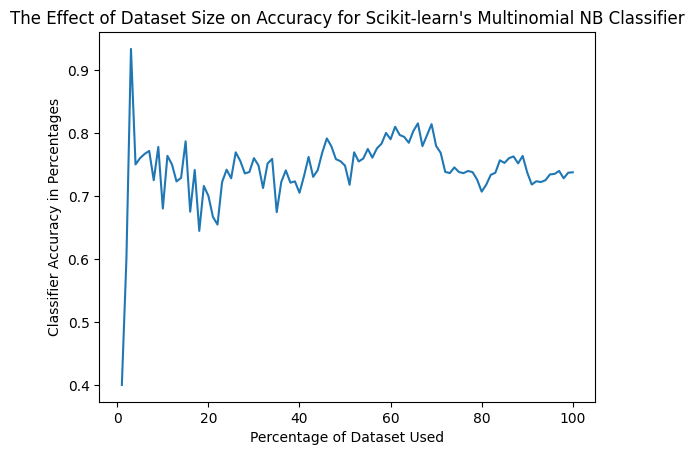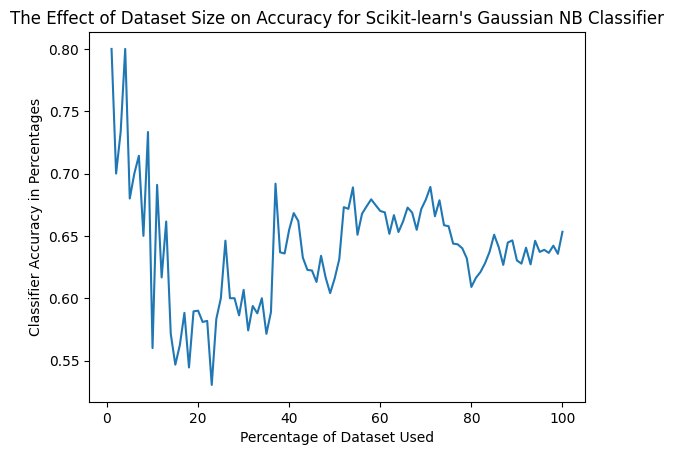

##**Additional Testing**

###**k-Nearest Neighbor**

I also applied the k-Nearest Neighbor classifier from Scikit-learn, to gain further insight into the classification task. The k-Nearest Neighbor classifier is not optimal for the task at hand, due to the extremely high dimensionality of the data, but its application demonstrates the effectiveness of the chosen strategies, i.e. Multinomial Naiive Bayes classifiers. The evaluation takes into account differing dataset sizes and distance heuristics. Increments of 10 (for the Manhattan distance) and of 5 (for the Euclidean and Cosine distances) were chosen over increments of 1 due to the sheer time burden of applying this classifier. Further, the cosine heuristic was so RAM intensive that it had to be capped at 90% of the dataset, otherwise the runtime would crash.

Regarding the heuristics, the cityblock/manhattan distance performed the worst overall in accuracy. It had an upwards trend, but was capped out at a little over 48% accuracy. The 'euclidean' distance measure performed slightly better. After increasing drastically in accuracy with around 35-40% of the dataset, accuracies hovered wildly between 48% and 62%. The 'cosine' distance measure performed the best, actually becoming more accurate with more data, hovering in around 62%-72%. This is impressive, as performance is comparable that of the Naiive Bayes classifiers. However, using more than 90% of the dataset causes the runtime to crash from lack of RAM.

In terms of time, all heuristics performed slower than the Naiive Bayes classifiers. The worst offender was the cityblock/manhattan distance, which clocked in at 17 minutes to run the whole dataset! Euclidean distance was much quicker, needing only 88.92 seconds for the entire dataset.

Between the extremely long processing times, the low accuracy scores, and the RAM burden, none of the heuristics nor the k-Nearest Neighbor classifier in general are adapt for this particular classification task.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
def scikitkNN(data, neighbors, metric):
  """The scikitkNN() is a function that prepares data to be used by the Scikit-learn
  library's k-Nearest Neighbor classifier. It automatically outputs time statistics,
  accuracy measurements, and the classification report from Scikit-learn.

  The function takes three arguments:
  (1) data : the dataset as a list of tuples with the first element containing
  the textual data and the second element its classification
  (2) neighbors : an integer for the number of neighboring points to be taken
  into consideration when classifying
  (3) metric : a string with the heuristic to be used in classifying. Viable
  heuristics can be found on the Scikit-learn's website"""

  start = time.time()
  print('Training...')

  ## create the vocabulary following the classifier's same procedure ##
  vocab = {}
  for tup in data:
    text = re.sub('[\"\'’‘”“,.?!;:*()><&|»«]', '', tup[0])
    text = re.sub('[-/—[]–]', ' ', text)
    for token in text.split():
        token = token.lower().strip()
        if token not in vocab:
          vocab[token] = 1
        else:
          vocab[token] += 1

  ## define the dimensions of the matrix ##
  matrix = lil_matrix((len(data), len(vocab)))

  ## assign ids to each token and article ##
  token_ids = {token : i for i, token in enumerate(vocab)}

  ## populate the matrix ##
  classifications = []
  for i, tup in enumerate(data):
    text = re.sub('[\"\'’‘”“,.?!;:*()><&|»«]', '', tup[0])
    text = re.sub('[-/—[]–]', ' ', text)

    classifications.append(tup[1])

    for token in text.split():
      token = token.lower().strip()
      matrix[i, token_ids[token]] += 1

  ## assigning variables for scikit-learn's classifiers ##
  X = matrix.toarray()
  y = np.array(classifications)

  ## clean up ##
  del vocab
  del matrix
  del token_ids
  del classifications

  ## data splitting ##
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0, train_size = 0.9)

  ## data preparation and normalization ##
  pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = neighbors, metric = metric))

  mid = time.time()
  print(f'     Data preparation elapsed {round(mid - start, 2)} seconds.\n')

  print('Testing Accuracy...')
  ## k-Nearest Neighbor Classifier ##
  pipe_knn.fit(X_train, y_train)
  y_pred = pipe_knn.predict(X_test)
  print(f"     Scikit-Learn's k-Nearest Neighbor Classifier's accuracy using the {metric.upper()} distance metric is {round(pipe_knn.score(X_test, y_test) * 100, 2)}% with {X_test.shape[0]} test cases.\n")
  accuracy = pipe_knn.score(X_test, y_test) * 100
  end = time.time()

  print('Metrics...')
  print('     k-Nearest Neighbor:\n', metrics.classification_report(y_test, y_pred, zero_division = 0))

  print('Time Statistics...')
  print(f'     k-Nearest Neighbor classification elapsed {round(end - mid, 2)} seconds.\n')
  print(f'     Total operation elapsed {round(end - start, 2)} seconds.\n')

  return accuracy

accuracy = scikitkNN(data, 3, 'euclidean')

Training...
     Data preparation elapsed 29.15 seconds.

Testing Accuracy...
     Scikit-Learn's k-Nearest Neighbor Classifier's accuracy using the EUCLIDEAN distance metric is 47.7% with 499 test cases.

Metrics...
     k-Nearest Neighbor:
               precision    recall  f1-score   support

           0       0.71      0.21      0.32       297
           1       0.43      0.88      0.58       202

    accuracy                           0.48       499
   macro avg       0.57      0.54      0.45       499
weighted avg       0.60      0.48      0.42       499

Time Statistics...
     k-Nearest Neighbor classification elapsed 82.71 seconds.

     Total operation elapsed 111.86 seconds.



In [ ]:
## Cityblock Distance ##
met = 'cityblock'

x = []
y = []
for num in range(10, 110, 10):
  print(f'Testing accuracy with {num}% of dataset on the {met.upper()} heuristic...')
  newdata = fnc.reducedata(data, (num / 100))
  accuracy = scikitkNN(newdata, 3, met)
  print('-'*150, '\n')

  x.append(num)
  y.append(accuracy)

plt.plot(x, y)
plt.ylabel('Classifier Accuracy in Percentages')
plt.xlabel('Percentage of Dataset Used')
plt.title(f"The Effect of Dataset Size on Accuracy for Scikit-learn's kNN Classifier - {met.upper()} Heuristic")
plt.show()

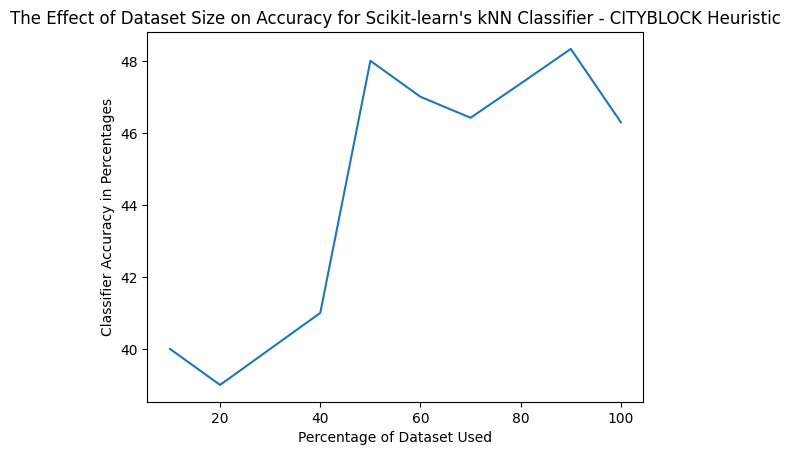

In [ ]:
## Euclidean Distance ##
met = 'euclidean'

x = []
y = []
for num in range(5, 105, 5):
  print(f'Testing accuracy with {num}% of dataset on the {met.upper()} heuristic...')
  newdata = fnc.reducedata(data, (num / 100))
  accuracy = scikitkNN(newdata, 3, met)
  print('-'*150, '\n')

  x.append(num)
  y.append(accuracy)

plt.plot(x, y)
plt.ylabel('Classifier Accuracy in Percentages')
plt.xlabel('Percentage of Dataset Used')
plt.title(f"The Effect of Dataset Size on Accuracy for Scikit-learn's kNN Classifier - {met.upper()} Heuristic")
plt.show()

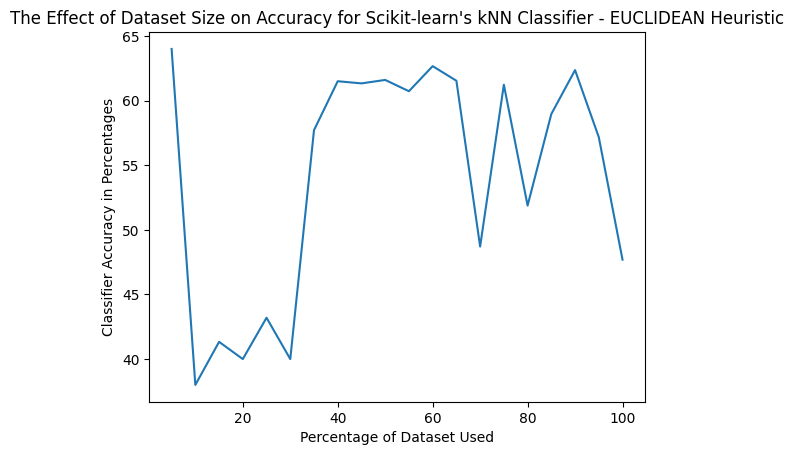

In [ ]:
## Cosine Distance ##
met = 'cosine'

x = []
y = []
for num in range(5, 95, 5):
  print(f'Testing accuracy with {num}% of dataset on the {met.upper()} heuristic...')
  newdata = fnc.reducedata(data, (num / 100))
  accuracy = scikitkNN(newdata, 3, met)
  print('-'*150, '\n')

  x.append(num)
  y.append(accuracy)

plt.plot(x, y)
plt.ylabel('Classifier Accuracy in Percentages')
plt.xlabel('Percentage of Dataset Used')
plt.title(f"The Effect of Dataset Size on Accuracy for Scikit-learn's kNN Classifier - {met.upper()} Heuristic")
plt.show()

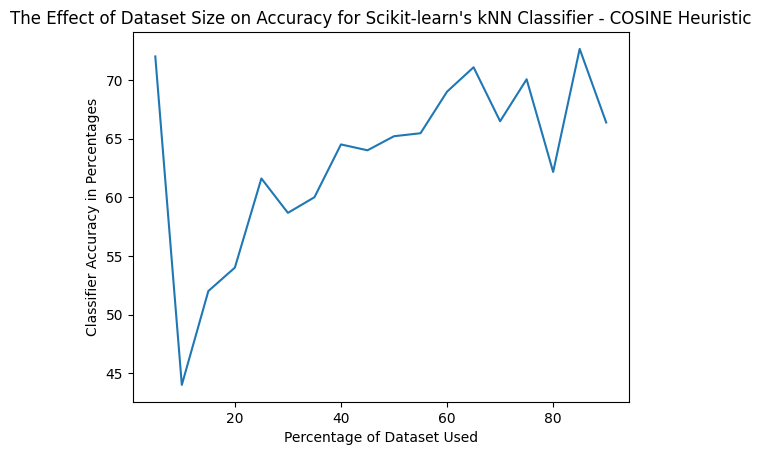

###*NewsClassifier*

When I originally wrote the *FakeNewsClassifier*, the accuracy readings were coming in at around 55% - hardly better than pure chance. I thought that this might be indicative of the nature of the task and of the architecture of the classifier. The classifier makes its classification decisions based on the probability of individual tokens (within a text) belonging to one of the given classes. Since the defining feature of fake news is its truth value, I thought this classifier might not be fit for the task, as it is bases itself on word choice.

Thus, I decided to try the classifier on a far easier task: classifying news articles with very clear and discrete classes. I found a dataset of news articles that fall into the topics 'business' and 'sports.' In doing so, I was able to uncover a series of mistakes that I had made in the implementation of the *FakeNewsClassifier*, that when corrected, brought the classifier up to the same level as the Multinomial Naiive Bayes classifier from Scikit-learn.

Below is the class *NewsClassifier* that I tweaked to be able to run this dataset. Since the classes 'business' and 'sports' have very distinct vocabularies, this task was far easier than the classification of fake news, and so, the classifier performed with near perfection, ranging from 98% to 100% accuracy. Like the previous classifiers, a test on differing dataset sizes was also performed.

In [ ]:
data = []
with open('Articles.csv', 'r', encoding='ISO-8859-1') as filein:
  reader = csv.reader(filein)
  for row in reader:
    data.append((row[0], row[1]))
random.shuffle(data)

stopwords = nltk.corpus.stopwords.words('english')


## Classifier ##
class NewsClassifier:
  """The NewsClassifier class applies a Multinomial Naiive Bayes classification
  on text data.

  To instantiate the class, five arguments must be passed:
  (1) data : the dataset as a list of tuples with the first element containing
  the textual data and the second element its classification
  (2) stopwords : a list of stopwords to be used to remove semantically vacant
  words from the vocabulary
  (3) skipbucket : the number of the bucket to be skipped in training and testing
  (4) datasize : an integer representing the decimal fraction of the dataset
  desired. For example if only 20% of the data is wanted, '.2' would be written
  for this argument. The default is '1,' i.e. all the data.
  (5) test : a Boolean value, which when set to true tests the accuracy of the
  classifier on the given dataset. Otherwise, the classifier is only trained,
  but not tested"""

  def __init__(self, data, stopwords, skipbucket, datasize = 1, test = False):
    start = time.time()
    print('Training...')

    self.vocabulary = {}
    self.prob = {}
    self.totals = {}
    self.stopwords = {}
    self.categories = []

    ## reduces the dataset ##
    data = self.reducedata(data, datasize)

    ## instantiates the buckets ##
    buckets = self.makebuckets(data)

    ## defines the categories ##
    for tup in data:
      try:
        self.categories.append(tup[1])
      except:
        pass

    self.categories = set(self.categories)

    ## sets the stopwords ##
    for word in stopwords:
      self.stopwords[word] = 1

    ## counts token frequency and token totals for each category ##
    for category in self.categories:
      (self.prob[category], self.totals[category]) = self.train(buckets, category, skipbucket, stopwords)

    ## simplifies the vocabulary ##
    tbdeleted = []
    for word in self.vocabulary:
      if self.vocabulary[word] < 3:
        tbdeleted.append(word)

    for word in tbdeleted:
      del self.vocabulary[word]

    ## computes the probabilities ##
    lenvocab = len(self.vocabulary)
    for category in self.categories:
      denominator = self.totals[category] + lenvocab
      for word in self.vocabulary:
        if word in self.prob[category]:
          count = self.prob[category][word]
        else:
          count = 1
        self.prob[category][word] = (float(count + 1) / denominator)

    mid = time.time()
    print(f'     Data preparation elapsed {round(mid - start, 2)} seconds.')

    ## tests the accuracy ##
    if test == True:
      print('\nTesting Accuracy...')
      self.test(buckets, skipbucket, output = True, mets = True)

    end = time.time()
    print('Time Statistics...')
    print(f'     Classification elapsed {round(end - mid, 2)} seconds.')
    print(f'     Total operation elapsed {round(end - start, 2)} seconds.')


  ## methods ##
  def train(self, buckets, category, skipbucket, stopwords):
    """The train() method does three tasks: (1) creates a vocabulary of all tokens
    and maintains a token count, (2) counts the frequency of every token, and (3)
    counts the total tokens (to be later used as a total count for each category).

    The method takes four arguments:
    (1) buckets : the training data divided previously into buckets
    (2) category : the current category being trained upon
    (3) skipbucket : the bucket number to be skipped to be used as a test set
    (4) stopwords : the list of stopwords to be excluded"""

    counts = {}
    total = 0
    for bucket, content in buckets.items():
      if bucket != skipbucket:
        for tup in content:
          text = re.sub('[\"\'’‘”“,.?!;:*()><&|»«]', '', tup[0])
          text = re.sub('[-/—[]–]', ' ', text)
          text = re.sub('strong', '', text)
          if tup[1] == category:
            tokens = text.split()

            for token in tokens:
              token = token.strip()
              token = token.lower()

              if token not in stopwords:
                self.vocabulary.setdefault(token, 0)
                self.vocabulary[token] += 1
                counts.setdefault(token, 0)
                counts[token] += 1
                total += 1

    return (counts, total)


  def makebuckets(self, data):
    """The makebuckets() method divides the dataset into 10 equally sized buckets.

    The method takes one argument:
    (1) data : the dataset in the form of a tuple with the first element containing
    the text data and the second element the classification"""

    divider = int(len(data) / 10)
    buckets = {}
    for i in range(0, 10):
      buckets[i + 1] = data[i * divider : (i * divider) + divider]

    return buckets


  def reducedata(self, data, datasize = 1):
    """The reducedata() method reduces the size of the dataset in order to test
    upon only a subsection of the data.

    The method takes two arguments:
    (1) data : the dataset
    (2) datasize : an integer representing the decimal fraction of the dataset
    desired. For example if only 20% of the data is wanted, '.2' would be written
    for this argument. The default is '1,' i.e. all the data."""

    bound = round(len(data) * datasize)

    return data[: bound]


  def classify(self, testcase):
    """The classify() method takes a single data element (one text), cleans its
    contents, and calculates the log probability of an individual token belonging
    to a specific class. It then adds that probability to a running total, which
    gets sorted to return the most likely class to which the text belongs.

    The method takes one argument:
    (1) testcase : the single text being considered for classification."""

    results = {}
    for category in self.categories:
      results[category] = 0

    text = re.sub('[\"\'’‘”“,.?!;:*()><&|»«]', '', testcase)
    text = re.sub('[-/—[]–]', ' ', text)
    text = re.sub('strong', '', text)
    tokens = text.split()

    for token in tokens:
      token = token.strip().lower()

      if token in self.vocabulary:
        for category in self.categories:
          try:
            results[category] += math.log(self.prob[category][token])
          except:
            self.prob[category].setdefault(token, 0)
            self.prob[category][token] += 1
            results[category] += math.log(self.prob[category][token])

    results = list(results.items())
    results.sort(key = lambda tuple: tuple[1], reverse = True)

    return results[0][0]


  def test(self, buckets, skipbucket, output = False, mets = False):
    """The test() method takes the test set, iterates through each text, and
    applies the classify() method to derive its predicted class. It counts the
    total cases and the total correct predictions to calculate the accuracy of
    the classifier on the given dataset.

    The method takes four arguments:
    (1) buckets : the training data divided previously into buckets
    (2) skipbucket : the bucket number previously skipped to be used here as a
    test set
    (3) output : a Boolean value, which when set to True outputs the accuracy of
    the classifier on the amount of test cases present in the bucket
    (4) mets : a Boolean value, which when set to True outputs the classification
    report from Scikit-Learn"""

    total = 0
    correct = 0
    y_test = []
    y_pred = []
    for bucket, content in buckets.items():
      if bucket == skipbucket:
        for tup in content:
          result = self.classify(tup[0])
          if result != None:
            total += 1
            y_test.append(tup[1])
            y_pred.append(result)

            if result == tup[1]:
              correct += 1

    if output == True:
      print(f'     Accuracy is {round(((float(correct) / total) * 100), 2)}% with {total} test cases.\n')

    if mets == True:
      print('Metrics...')
      print(metrics.classification_report(y_test, y_pred))

    return float(correct) / total

nc = NewsClassifier(data, stopwords, 5, test = True)

Training...
     Data preparation elapsed 3.09 seconds.

Testing Accuracy...
     Accuracy is 98.51% with 269 test cases.

Metrics...
              precision    recall  f1-score   support

    business       0.98      0.99      0.99       136
      sports       0.99      0.98      0.98       133

    accuracy                           0.99       269
   macro avg       0.99      0.99      0.99       269
weighted avg       0.99      0.99      0.99       269

Time Statistics...
     Classification elapsed 0.1 seconds.
     Total operation elapsed 3.19 seconds.


In [ ]:
## NewsClassifier ##
x = []
y = []
for num in range(1, 101, 1):
  print(f'Testing accuracy with {num}% of dataset...')
  nc = NewsClassifier(data, stopwords, 5, (num / 100), test = True)

  newdata = nc.reducedata(data, (num / 100))
  buckets = nc.makebuckets(newdata)

  accuracy = nc.test(buckets, 5)
  print('\n', '-'*150, '\n')

  x.append(num)
  y.append(accuracy)

plt.plot(x, y)
plt.ylabel('Classifier Accuracy in Percentages')
plt.xlabel('Percentage of Dataset Used')
plt.title('The Effect of Dataset Size on Accuracy for the NewsClassifier')
plt.show()

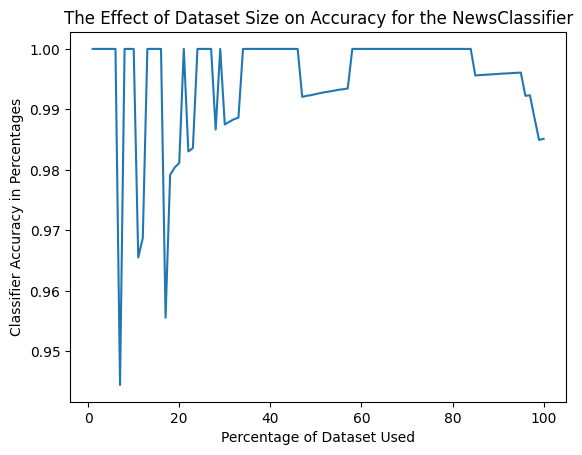